In [215]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import Boltzmann
from tqdm import tqdm

======================================================================================================================================================================================================================================================================================

**Pre-built libraries:**

* **NumPy:** Provides numerical computing tools for arrays, linear algebra, random number generation, etc. 
* **SciPy:** Extends NumPy with functions for optimization, integration, and other scientific computing tasks.
* **Matplotlib:** Used for creating publication-quality plots of the simulation results.

**Functions:**

1. **initialize_lattice(lattice_type, lattice_constant):**
    * Defines the target metal lattice structure (FCC, BCC, etc.)
    * Generates initial positions of metal atoms based on the chosen lattice and constant using NumPy functions.

2. **lj_potential(r):**
    * Implements the Lennard-Jones potential formula to calculate the interaction energy between two atoms based on their interatomic distance (r) using NumPy.

3. **metal_potential(configuration):**
    * Defines the interaction potential specific to the chosen metal (e.g., embedded-atom method) based on the atomic configuration. Libraries like LAMMPS or USER may be helpful for pre-defined potentials. 

4. **hamiltonian(configuration):**
    * Calculates the total energy of the system by summing the LJ potential between ions (using function 2) and the metal potential (using function 3) for a given atomic configuration.

5. **metropolis_mcmc(positions, potential, temperature):**
    * Implements the Metropolis Monte Carlo algorithm using SciPy functions. This iteratively proposes new positions for ions, evaluates their energy using the potential (function 4), and accepts or rejects them based on a Boltzmann factor at a specific temperature.

6. **binary_collision(ion_position, ion_velocity, metal_positions):**
    * Identifies metal atoms struck by the ion based on collision geometry.
    * Updates positions and velocities of these metal atoms after the collision using classical mechanics equations. This might involve functions for momentum transfer and energy exchange.

7. **calculate_sputtering_yield(metal_energies, surface_binding_energy):**
    * Analyzes the energies of metal atoms after collision (from function 6).
    * Identifies sputtered atoms with energy exceeding the surface binding energy.
    * Tracks the number of sputtered atoms and calculates the average over multiple iterations to get the sputtering yield.

8. **calculate_backscattering(sputtered_positions, ejection_velocities):**
    * Analyzes the positions and velocities of sputtered atoms (from function 6).
    * Calculates the ejection angles for each sputtered atom.
    * Generates a histogram or other representation of the angular distribution of sputtered atoms.

9. **calculate_sputter_depth(ion_positions):**
    * Tracks the final positions of ions after collisions.
    * Calculates the average depth they penetrate the target lattice. 

10. **update_lattice(metal_positions, sputtered_atoms):**
    * Identifies sputtered atoms from function 7.
    * Removes sputtered atoms from the simulation box and metal atom positions array.
    * Might involve functions to rearrange neighboring atoms to fill vacancies in the lattice (depending on the chosen metal potential).

11. **plot_results(sputtering_yield, backscattering, sputter_depth):**
    * Uses Matplotlib to create plots of the obtained results:
        * Sputtering yield vs. relevant parameter (e.g., ion energy)
        * Backscattering distribution of ejected metal atoms
        * Depth profile of the sputtered target

In [216]:
# Define the side length of the cubic space
length = 100

# Create a 3D numpy array to represent the cubic space
cubic_space = np.zeros((length, length, length))

# Create the lattice within the cubic space
lattice_height = length // 4
cubic_space[:, :, :lattice_height] = 1  # Assign a value of 1 to represent the lattice

particle_initial_permit = 2*lattice_height  # The initial permit of the particles
# Initialize the free particles within the cubic space
num_particles = 30  # Number of free particles
free_space = cubic_space[:, :, particle_initial_permit:]  # The space above the lattice
# free_space = cubic_space[:, :, lattice_height:]
free_space_indices = np.argwhere(free_space == 0)  # Indices of the free space
selected_indices = np.random.choice(len(free_space_indices), num_particles, replace=False)  # Randomly select indices for the free particles
free_particles_positions = free_space_indices[selected_indices]  # Get the positions of the free particles
cubic_space[free_particles_positions[:, 0], free_particles_positions[:, 1], free_particles_positions[:, 2] + particle_initial_permit] = 2  # Assign a value of 2 to represent the free particles
# cubic_space[free_particles_positions[:, 0], free_particles_positions[:, 1], free_particles_positions[:, 2] + lattice_height] = 2

## Defining particle parameters

(30, 3)


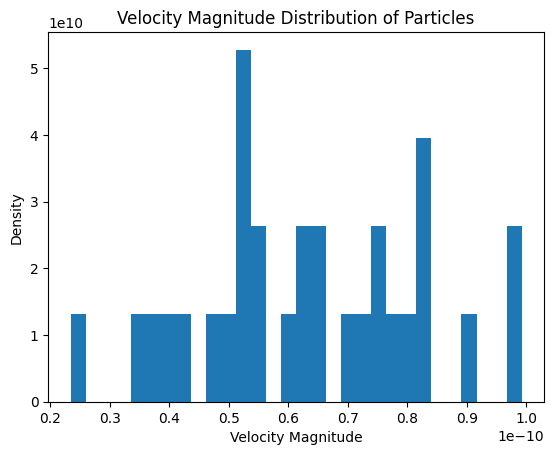

In [217]:
#the position of particle is always x,y,z+particle_initial_permit
#randomly initialize velocity of the particles in 3d a given range of values selected using temperature
q = 1.6e-19  # Charge of the particles
temperature = 300  # Temperature in Kelvin
mass = 1  # Mass of the particles
velocity_range = np.sqrt(3*Boltzmann*temperature/mass)/1.732  # The range of velocity values in each direction
num_particles = len(free_particles_positions)  # Number of free particles
velocities = np.random.uniform(-velocity_range, velocity_range, (num_particles, 3))  # Randomly initialize the velocities of the particles
print(velocities.shape)
#visualize the particles velocity distribution
# Calculate the norm of each velocity vector
velocity_magnitudes = np.linalg.norm(velocities, axis=1)

# Create a histogram of the velocity magnitudes
plt.hist(velocity_magnitudes, bins=30, density=True)

# Set labels and title
plt.xlabel('Velocity Magnitude')
plt.ylabel('Density')
plt.title('Velocity Magnitude Distribution of Particles')

# Show the plot
plt.show()


## Average velocity

In [220]:
k = 1.380649e-23  # Boltzmann constant in J/K
T = 500  #Kelvin
v_avg = np.sqrt((8 * k * T) / (np.pi * mass))
v=np.array([v_avg/1.732,v_avg/1.732,v_avg/1.732])
print(v)

[7.65506377e-11 7.65506377e-11 7.65506377e-11]


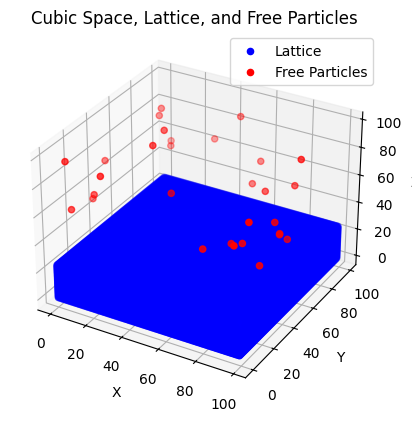

In [221]:
# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the x, y, and z coordinates of the lattice and free particles
lattice_x, lattice_y, lattice_z = np.where(cubic_space == 1)
free_particles_x, free_particles_y, free_particles_z = np.where(cubic_space == 2)

# Plot the lattice and free particles
ax.scatter(lattice_x, lattice_y, lattice_z, color='blue', label='Lattice')
ax.scatter(free_particles_x, free_particles_y, free_particles_z, color='red', label='Free Particles')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cubic Space, Lattice, and Free Particles')
ax.legend()

# Show the plot
plt.show()

## ION ION interactions and potentials

In [223]:
#define electric and magnetic field vectors
# Define the electric field vector
E = np.array([0, 0, 1])

# Define the magnetic field vector
M = np.array([0, 0, 0])

In [222]:
size = len(free_particles_positions)
charges = np.full(size, q)
masses = np.full(size, mass)

In [181]:
def calculate_forces(particles, velocities, charges, epsilon, sigma, E, B):
    """
    Calculates the forces on the particles due to the electric field, magnetic field, and Lennard-Jones interactions.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    """
    # Initialize forces as float
    forces = charges[:, np.newaxis] * E.astype(float)

    # Add forces due to Lennard-Jones interactions
    for i in range(len(particles)):
        for j in range(i+1, len(particles)):
            r = particles[j] - particles[i]
            r_norm = np.linalg.norm(r)
            F = 24 * epsilon * ((2 * (sigma / r_norm)**12) - (sigma / r_norm)**6) * (r / r_norm)
            forces[i] += F
            forces[j] -= F

    # Add forces due to magnetic field
    forces += charges[:, np.newaxis] * np.cross(velocities, B)

    return forces

def velocity_verlet(particles, velocities, charges, masses, epsilon, sigma, E, B, dt):
    """
    Implements the Velocity Verlet algorithm to update particle positions and velocities.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    dt: time step
    """
    # Calculate forces
    forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update positions
    particles = particles + velocities * dt + 0.5 * (forces / masses[:, np.newaxis]) * dt**2

    # Calculate new forces
    new_forces = calculate_forces(particles, velocities, charges, epsilon, sigma, E, B)

    # Update velocities
    velocities = velocities + 0.5 * ((forces + new_forces) / masses[:, np.newaxis]) * dt

    return particles, velocities


In [214]:
# Define the number of iterations for the simulation and the z-coordinate threshold
N = 50000
z_threshold = lattice_height

# Initialize counter for the number of particles that reach or go below the z-coordinate threshold
threshold_count = 0

# Run the simulation
for iteration in range(N):
    # Run Velocity Verlet algorithm
    particles, velocities = velocity_verlet(particles, velocities, charges, masses, 1.0, 1.0, E, M, 0.05)

    # Check which particles have reached or gone below the z-coordinate threshold
    below_threshold = particles[:, 2]+particle_initial_permit <= z_threshold
    threshold_count += np.sum(below_threshold)

print("Number of times particles reached or went below the z-coordinate threshold:", threshold_count)

Number of times particles reached or went below the z-coordinate threshold: 50000


In [183]:
def lennard_jones_potential(r, epsilon, sigma):
    """
    Calculates the Lennard-Jones potential between two particles.
    r: distance between the particles
    epsilon: depth of the potential well
    sigma: distance at which the potential is zero
    """
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

def hamiltonian(particles, velocities, charges, masses, epsilon, sigma, E, B):
    """
    Calculates the Hamiltonian (total energy) of a system of particles.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    temperature: temperature of the system
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    """
    # Calculate kinetic energy from the magnetic field
    kinetic_energy = 0.5 * np.sum(masses * np.sum(velocities**2, axis=1)) + np.sum(charges * np.cross(velocities, B)**2 / (2 * masses))

    # Calculate potential energy from the electric field and Lennard-Jones interactions
    potential_energy = -np.sum(charges * E * particles)
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            r = np.linalg.norm(particles[i] - particles[j])
            potential_energy += lennard_jones_potential(r, epsilon, sigma)

    return kinetic_energy + potential_energy

In [184]:
def binary_collision_model(particles, velocities, charges, masses, epsilon, sigma, E, B, lattice_boundary, energy_threshold):
    """
    Implements a binary collision model.
    particles: positions of the particles
    velocities: velocities of the particles
    charges: charges of the particles
    masses: masses of the particles
    epsilon: depth of the potential well in the Lennard-Jones potential
    sigma: distance at which the potential is zero in the Lennard-Jones potential
    E: electric field
    B: magnetic field
    lattice_boundary: boundary of the lattice
    energy_threshold: energy threshold for a collision
    """
    Y = 0
    sputtered_particles = []
    sputtered_positions = []
    for i in range(len(particles)):
        # Check if the particle has reached the lattice boundary
        if np.any(particles[i][2]+particle_initial_permit <= lattice_boundary):
            # Calculate the energy of the particle
            particle_energy = hamiltonian(np.array([particles[i]]), np.array([velocities[i]]), np.array([charges[i]]), np.array([masses[i]]), epsilon, sigma, E, B)

            # Check if the energy of the particle is equal to or greater than the energy threshold
            if np.abs(particle_energy) >= energy_threshold:
                # Collision occurs, update the velocity of the particle
                velocities[i] = -velocities[i]
                Y += 1 

                # If the energy exceeds the threshold, the particle is sputtered
                sputtered_particles.append(i)
                sputtered_positions.append(particles[i])

    return particles, velocities, charges, masses, sputtered_particles, sputtered_positions, Y

In [185]:
# Define the number of iterations for the simulation
num_iterations = 1000
epsilon = 1.0
sigma = 1.0
B = M
dt = 0.05
energy_threshold = 0
# Initialize counters for the number of particles that reach the boundary and surpass the energy threshold
boundary_count = 0
threshold_count = 0
particles = free_particles_positions.copy()
# Run the simulation
for iteration in tqdm(range(num_iterations)):
    # Run Velocity Verlet algorithm
    particles, velocities = velocity_verlet(particles, velocities, charges, masses, epsilon, sigma, E, B, dt)

    # Run binary collision model
    particles, velocities, charges, masses, sputtered_particles, sputtered_positions, Y = binary_collision_model(particles, velocities, charges, masses, epsilon, sigma, E, B, lattice_height, energy_threshold)
    # Update counters
    boundary_count += len(sputtered_particles)
    threshold_count += Y

print("Number of particles that reached the boundary:", boundary_count)
print("Number of particles that surpassed the energy threshold:", threshold_count)

100%|██████████| 1000/1000 [00:07<00:00, 128.46it/s]

Number of particles that reached the boundary: 0
Number of particles that surpassed the energy threshold: 0


In [192]:
import numpy as np

# Define the parameters for the test
particles1 = np.array([[0, 0, 0], [1, 0, 0]])
velocities1 = np.array([[0, 0, 0], [0, 0, 0]])
charges1 = np.array([1, -1])
masses1 = np.array([1, 1])
epsilon1 = 1
sigma1 = 1
E1 = np.array([0, 0, 1])
B1 = np.array([0, 0, 0])
lattice_boundary1 = 1
energy_threshold1 = 0.1

# Run the lennard_jones_potential function
potential = lennard_jones_potential(1, epsilon, sigma)
print("Lennard-Jones potential:", potential)

# Run the binary_collision_model function
new_particles, new_velocities, new_charges, new_masses, sputtered_particles, sputtered_positions, Y = binary_collision_model(particles, velocities, charges, masses, epsilon, sigma, E, B, lattice_boundary, energy_threshold)
print("New particles:", new_particles)
print("New velocities:", new_velocities)
print("Sputtered particles:", sputtered_particles)
print("Sputtered positions:", sputtered_positions)
print("Number of collisions:", Y)

Lennard-Jones potential: 0.0
New particles: [[0 0 0]
 [1 0 0]]
New velocities: [[0 0 0]
 [0 0 0]]
Sputtered particles: []
Sputtered positions: []
Number of collisions: 0
